In [52]:
# File import statements

import matplotlib.pyplot as plt
import matplotlib.cm

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Row, functions, Column
from pyspark.sql.types import *

import numpy as np
import sys

from pyspark.ml import Pipeline, Estimator
from pyspark.ml.feature import SQLTransformer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.regression import (LinearRegression,
                                   GBTRegressor,
                                   RandomForestRegressor,
                                   DecisionTreeRegressor)

import findspark
findspark.init() # This require to have SPARK_HOME environment variable to be set

from weather_tools import *

spark = SparkSession.builder.appName('weather related prediction').getOrCreate()



assert sys.version_info >= (3, 5)  # make sure we have Python 3.5+
assert spark.version >= '2.2'  # make sure we have Spark 2.2+

In [53]:
# Functions related to data processing

def get_df_column(df, column):
    return [float(i[column]) for i in df.select(column).collect()]

def get_data(inputloc, tablename='data'):
    schema = StructType([
        StructField('station', StringType(), False),
        StructField('date', DateType(), False),
        StructField('latitude', FloatType(), False),
        StructField('longitude', FloatType(), False),
        StructField('elevation', FloatType(), False),
        StructField('tmax', FloatType(), False),
    ])
    data = spark.read.csv(inputloc, schema=schema)
    data.createOrReplaceTempView(tablename)
    return data

#-----------------------------------------------------------------------------

In [3]:
# Function related to plotting the data

def plot_temp(df, m, plottable_col, label_text):
    lats = get_df_column(df, 'latitude')
    lons = get_df_column(df, 'longitude')
    temp_value = get_df_column(df, plottable_col)
    temp_value = [int(i) for i in temp_value]
    x, y = m(lons,lats)
    m.scatter(x, y, marker='o',c=temp_value, cmap="jet", alpha = 0.5)
    m.colorbar(label=label_text)

def get_map(map_projection='cyl'):
    m = Basemap(resolution='c', # c, l, i, h, f or None
                projection=map_projection,
                lat_0=0, lon_0=0,
                llcrnrlon=-180.0, llcrnrlat= -90.0, urcrnrlon=180.0, urcrnrlat=90.0)

    m.drawmapboundary()
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    return m

#-----------------------------------------------------------------------------

In [4]:
# Prediction model relelvant code copied from Assignment 5b,
# this also required to import weather_tools which was provided by Mr. Greg Baker
# Original Author for method doy_query, make_weather_trainers, and get_best_weather_model is Mr. Greg Baker

def doy_query():
    return """SELECT *, dayofyear( date ) AS doy FROM __THIS__"""

def make_weather_trainers(trainRatio,
                          estimator_gridbuilders,
                          metricName=None):
    """Construct a list of TrainValidationSplit estimators for weather data
       where `estimator_gridbuilders` is a list of (Estimator, ParamGridBuilder) tuples
       and 0 < `trainRatio` <= 1 determines the fraction of rows used for training.
       The RegressionEvaluator will use a non-default `metricName`, if specified.
    """
    feature_cols = ['latitude', 'longitude', 'elevation', 'doy']
    column_names = dict(featuresCol="features",
                        labelCol="tmax",
                        predictionCol="tmax_pred")

    getDOY = doy_query()
    sqlTrans = SQLTransformer(statement=getDOY)

    feature_assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol=column_names["featuresCol"])
    ev = (RegressionEvaluator()
          .setLabelCol(column_names["labelCol"])
          .setPredictionCol(column_names["predictionCol"])
    )
    if metricName:
        ev = ev.setMetricName(metricName)
    tvs_list = []
    for est, pgb in estimator_gridbuilders:
        est = est.setParams(**column_names)

        pl = Pipeline(stages=[sqlTrans, feature_assembler, est])

        paramGrid = pgb.build()
        tvs_list.append(TrainValidationSplit(estimator=pl,
                                             estimatorParamMaps=paramGrid,
                                             evaluator=ev,
                                             trainRatio=trainRatio))
    return tvs_list

def get_best_weather_model(data):
    train, test = data.randomSplit([0.75, 0.25])
    train = train.cache()
    test = test.cache()

    estimator_gridbuilders = [
        estimator_gridbuilder(
            RandomForestRegressor(),
            dict(
                maxDepth=[5],
                maxBins=[5],
                numTrees=[20]
            )
        ),
        estimator_gridbuilder(
            GBTRegressor(maxIter=100),
            dict()
        )

    ]
    metricName = 'r2'
    tvs_list = make_weather_trainers(.2, # fraction of data for training
                                     estimator_gridbuilders,
                                     metricName)
    ev = tvs_list[0].getEvaluator()
    scorescale = 1 if ev.isLargerBetter() else -1
    model_name_scores = []
    # print(list(tvs_list).count())
    for tvs in tvs_list:
        model = tvs.fit(train)
        test_pred = model.transform(test)
        score = ev.evaluate(test_pred) * scorescale
        model_name_scores.append((model, get_estimator_name(tvs.getEstimator()), score))
    best_model, best_name, best_score = max(model_name_scores, key=lambda triplet: triplet[2])
    print("Best model is %s with validation data %s score %f" % (best_name, ev.getMetricName(), best_score*scorescale))
    return best_model

#-----------------------------------------------------------------------------

In [47]:
# Parsing data from source 'tmax-2'

inputloc = 'tmax-2'

# tmax-2 Data
data = get_data(inputloc).cache()

# Splillting data for training and test based on weather data
train_data, test_data = data.randomSplit([0.75, 0.25])

# Getting all the data associated with 2016, 2014 and 2010
data_2016 = data.filter(functions.year(data["date"]) == (functions.lit(2016))).select('station', 'latitude', 'longitude', 'tmax').cache() 
data_2010 = data.filter(functions.year(data["date"]) == (functions.lit(2010))).select('station', 'latitude', 'longitude', 'tmax') 
data_2014 = data.filter(functions.year(data["date"]) == (functions.lit(2014))).select('station', 'latitude', 'longitude', 'tmax') 
data.unpersist()

#-----------------------------------------------------------------------------

DataFrame[station: string, date: date, latitude: float, longitude: float, elevation: float, tmax: float]

In [54]:
# Get 2016 avg temp data

avg_temp_2016_data = data_2016.groupBy('station').agg({"tmax": "avg"}).withColumnRenamed('avg(tmax)', 'tavg')
data_2016_avg_temp = data_2016.join(avg_temp_2016_data, 'station').select('station', 'latitude', 'longitude', 'tavg').distinct() 
data_2016.unpersist()
station_with_lat_lon = data_2016_avg_temp.select('station', 'latitude', 'longitude')

#-----------------------------------------------------------------------------

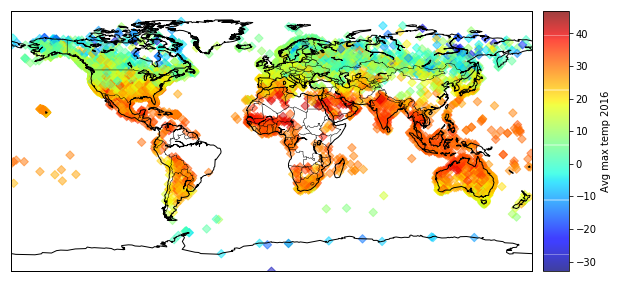

In [58]:
# Plot 2016 avg temp data

fig, ax = plt.subplots(figsize=(10,5))
m = get_map()
plot_temp(data_2016_avg_temp, m, 'tavg','Avg max temp 2016')
plt.show()
fig.savefig('Avg_tmax_temp_2016')

#-----------------------------------------------------------------------------

In [50]:
# Get Avg temp increase from 2010 to 2014

avg_temp_2010_data = data_2010.groupBy('station').agg({"tmax": "avg"}).withColumnRenamed('avg(tmax)', 'tavg_2010')
avg_temp_2014_data = data_2014.groupBy('station').agg({"tmax": "avg"}).withColumnRenamed('avg(tmax)', 'tavg_2014')

avg_temp_inc_2010_2014 = avg_temp_2010_data.join(avg_temp_2014_data, 'station')

avg_temp_inc_2010_2014 = avg_temp_inc_2010_2014 \
                        .select('station', avg_temp_inc_2010_2014['tavg_2010'] - avg_temp_inc_2010_2014['tavg_2014']) \
                        .withColumnRenamed('(tavg_2010 - tavg_2014)', 'increase') \
                        .join(station_with_lat_lon, 'station')

#-----------------------------------------------------------------------------            

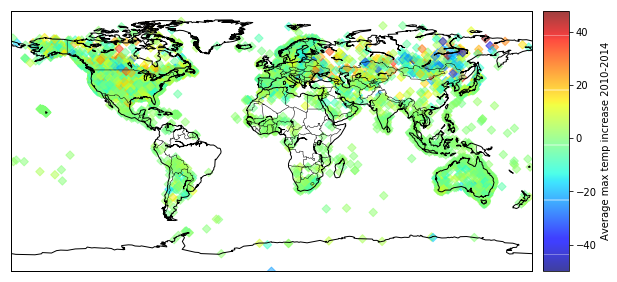

In [57]:
# Draw plot in temp diff

fig, ax = plt.subplots(figsize=(10,5))
m = get_map()
plot_temp(avg_temp_inc_2010_2014, m, 'increase', 'Average max temp increase 2010-2014')
plt.show()
fig.savefig('avg_temp_inc_2010_2014-2016')

#-----------------------------------------------------------------------------

In [10]:
# Import elevation grid and test whether it is imported properly or not

import elevation_grid as eg
import numpy as np

import time
from datetime import date

el = eg.get_elevation(50.0, -123.0)
print("Elevation library is working")
print("Example: Coordinate (50.0, -123.0) is a place near Whistler, BC is {} m above sea level".format(el))

#-----------------------------------------------------------------------------

Elevation library is working
Example: Coordinate (50.0, -123.0) is a place near Whistler, BC is 1541.0 m above sea level


In [11]:
# Get best model based on train data

model = get_best_weather_model(train_data)
print("Best parameters on test data:\n", get_best_tvs_model_params(model))

#-----------------------------------------------------------------------------

Best model is GBTRegressor with validation data r2 score 0.827926
Best parameters on test data:
 ('r2', 0.8251709758538857, {})


In [12]:
# Create lat, lon grid based on the code provided by Mr. Bergner

lats, lons = np.meshgrid(np.arange(-90,90,1.0),np.arange(-180,180,1.0))
coords = np.array([np.array([late,lone]).T for late,lone in zip(lats,lons)])
coords = coords.reshape((coords.shape[0] * coords.shape[1], 2))
coords_elev_datas = [( date.today(), float(lat), float(lon), float(eg.get_elevation(lat, lon)) ) for lat, lon in coords]

schema = StructType([
    StructField('date', DateType(), False),
    StructField('latitude', FloatType(), False),
    StructField('longitude', FloatType(), False),
    StructField('elevation', FloatType(), False)
])

geo_datas = spark.createDataFrame(coords_elev_datas, schema=schema)

# Get prediction from our model
data_pred = model.transform(geo_datas).drop("features")
data_pred = data_pred.select('latitude', 'longitude', 'tmax_pred')


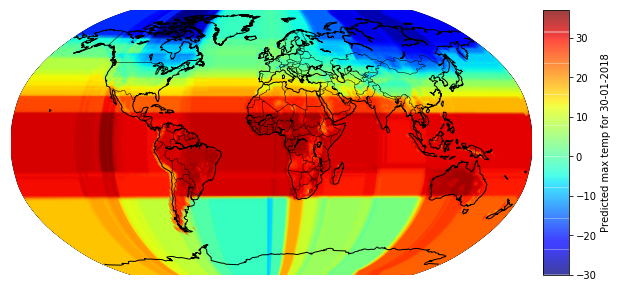

In [59]:
# Plot our prediction

fig, ax = plt.subplots(figsize=(10,5))
m = get_map('robin')
plot_temp(data_pred, m, 'tmax_pred', 'Predicted max temp for {}'.format(date.today().strftime("%d-%m-%Y")))
plt.show()
fig.savefig('Predicted temp for today')

#-----------------------------------------------------------------------------

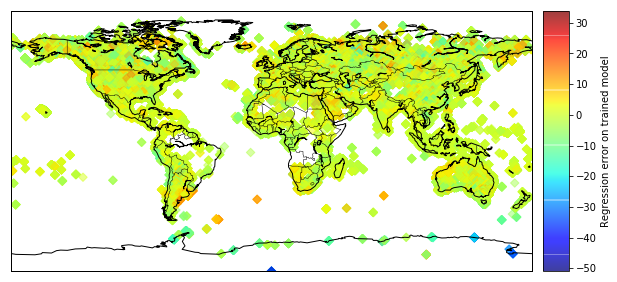

In [60]:
# Get prediction in test value and plot regression error

test_data_pred = model.transform(test_data).drop("features")
test_data_pred = test_data_pred.select('station', 'latitude', 'longitude', test_data_pred['tmax'] - test_data_pred['tmax_pred'])
test_data_pred = test_data_pred.withColumnRenamed('(tmax - tmax_pred)', 'error')

fig, ax = plt.subplots(figsize=(10,5))
m = get_map()
plot_temp(test_data_pred, m, 'error', 'Regression error on trained model')
plt.show()
fig.savefig('Error_on_trained_model.png')